In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(2727)

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Model(tf.Module):
    # Heat equation PINN-solver. 
    def __init__(self, layers_size, num_iter, num_data):

        self.num_iter = num_iter
        self.num_data = num_data
        self.input_dim = layers_size[0]
        self.layers = layers_size
        # List of tf.Tensor objects
        self.W = []

        # Initializer
        init = tf.initializers.GlorotUniform(seed=333)

        for i in range(len(layers_size) - 1):
            input_dim = layers_size[i]
            output_dim = layers_size[i + 1]

            w = tf.Variable(init([output_dim, input_dim], dtype='float64'), trainable=True, name=f'w{i+1}')
            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.learning_rate = 0.0001
    
    

    def evaluate(self, x):
        """Evaluates the NN at x.

        Args:
            x : Shape must match the NN input shape.

        Returns:
            tf.Tensor: u_theta(x)
        """
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
    
    def function_to_learn(self, data):
        """Function to lear.

        Args:
            data: single data point.

        Returns:
            float.
        """
        return (data[0][0] ** 2) * (2-data[0][0])
   
    ##################### LOSS METHODS ###########################

    def loss(self, data):
        weight = 2 / self.num_data
        return weight * tf.square(self.evaluate(data) - self.function_to_learn(data))

    ##################### TRAINING METHODS ###########################


    def apply_gradients(self, gradients_list: list):
        """Updates the parameters according to SGD iteration.

        Args:
            gradients_list (list): list of tf.Tensor
        """
        for w, g in zip(self.W, gradients_list):
            w = w.assign_sub(self.learning_rate * g)
    
    
    def train(self):
        end_point = 2
        num_data = self.num_data
        data_set = [[[x]] for x in np.random.uniform(0,2,self.num_data)]
        l = []
        for _ in tqdm(range(self.num_iter)):
            with tf.GradientTape() as tape:
                tape.watch(self.W)
                target = sum(self.loss(d) for d in data_set)
            grads = tape.gradient(target, self.W)
            #self.apply_gradients(grads)
            for w, g in zip(self.W, grads):
                w = w.assign_sub(self.learning_rate * g)
            l.append(target)
        return l

            

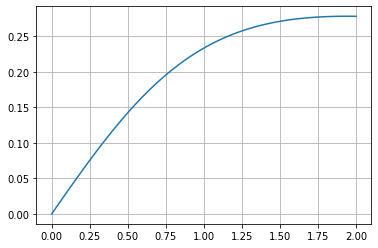

In [3]:
d = 30
model = Model([1,d,d,d,d,d,d,1], 5000, 500)
x = np.linspace(0,2,100)
y = [model.evaluate([[v]])[0][0].numpy() for v in x]
plt.plot(x,y)
plt.grid()


In [4]:
loss = model.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

  2%|▏         | 118/5000 [02:58<2:03:20,  1.52s/it]


KeyboardInterrupt: 

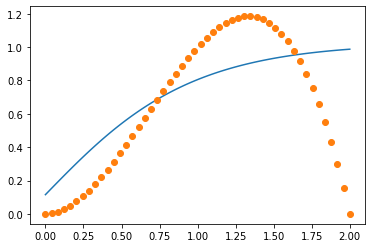

In [105]:
x = np.linspace(0,2,100)
y = [model.evaluate([[v]])[0][0].numpy() for v in x]
plt.plot(x,y)
x = np.linspace(0,2,50)
z = [(v**2)*(2-v) for v in x]
plt.plot(x,z,'o')


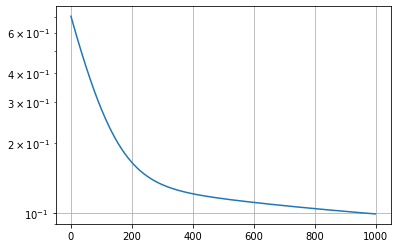

In [106]:
values = list(map(lambda v: v[0].numpy(), loss))
plt.plot(values)
plt.grid()
plt.yscale("log")